## Package Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
np.random.seed(42)
import pandas as pd
import seaborn as sns
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)  
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from matplotlib.colors import get_named_colors_mapping
get_named_colors_mapping()["r"] = "#ff6961"
get_named_colors_mapping()["b"] = "#1AA7EC"
plt.rcParams.update({'font.size': 12})
from meteostat import Point, Daily
import time
from src.data import extract

import numpyro
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS
import statsmodels.api as sm
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
from jax import lax

import statsmodels.tsa.stattools as sts
from sklearn.model_selection import train_test_split
from sklearn.metrics import (mean_squared_error, r2_score, mean_absolute_error, 
                             mean_absolute_percentage_error)


## Introduction

People hate delayed public transportation. Every year thousands of minutes are spent waiting on delayed public transportation including delayed flights. 4.5 million passengers were affected by cancellations, delays, and overbookings of flights and the eligible value of compensation approached 2 billion euros [1]. The goal of this project is to model the number of minutes a flight is delayed. To simplify the complex problem, initially, a single airport in the US, Denver Airport, is modeled. Moreover, delayed minutes are simplified to departure delay minutes, which means that it is modeled how many the flight departure is delayed compared to the scheduled departure time. Given these simplifications, it is reasonable that if the previous flight at a terminal was delayed in its departure, the chances will be higher that the next flight will be delayed as well. There might also be a correlation between weather conditions and departure delay times, as the weather for instance can affect how difficult it is to taxi between runways [2]. 

Several Bayesian models are tried out in the project, from simple to complex. The simple models are linear regression, an AR(1), and AR(2). The more complex models are an Ar(2) model that includes external features, a feedforward neural network, and a convolutional neural network. The convolutional neural network will model the departure delay minutes for several airports, whereas the more simple airports only will model a single airport. 


Given the goal of predicting the delay time of domestic flights in the US. The project aims at answering the following questions: 

- How can the delay of aircraft be predicted?
- How much does weather impact the delay time of the aircraft?
- What limitations are there in the data and what strategies can be used to overcome them?


## Data Introduction

The dataset used is part of the Reporting Carrier On-Time Performance Dataset that contains information on domestic flights in the US reported to the United States Bureau of Transportation Statistics from January 2018 to July 2022. The dataset is available for download at [Kaggle](https://www.kaggle.com/datasets/robikscube/flight-delay-dataset-20182022). Each flight is described in the dataset with basic information such as time, departure time, arrival time at the airport, the number of minutes the time was delayed, and some information about the reason the flight was delayed. The data will be enriched with weather features from [Meteostat Developers API](https://dev.meteostat.net/api/point/daily.html) with information about wind speed, wind direction, temperature, and precipitation.


The target variable that will be modeled is the *DepDalayMinutes* feature which shows the number of minutes a flight is delayed from the scheduled departure. The input variable is the *FlightDate* feature. To transform the data to a time series that can be modeled, the mean delay time per day is calculated and this is the target variable in the model.

## Exploratory Data analysis

## Data Preprocessing

In this section of the notebook, the data is cleaned from discrepancies and the time series is aggregated on a daily basis. The data is also enriched with weather data retrieved from Meteostat's API.

In [4]:
def prep_data(df):
    """
    Preprocess data to be used for modeling.
    """
    # select columns
    col_list =['FlightDate','Origin','DepDelayMinutes']
    df = df[col_list]
    
    # convert to datetime
    df['FlightDate'] = pd.to_datetime(df['FlightDate'])
    start_date = df['FlightDate'].min()
    end_date = df['FlightDate'].max()
    
    # select departure airport
    df = df[df['Origin'] == 'DEN']

    # set cancelled flights to zero delay min
    df['DepDelayMinutes'] =  df['DepDelayMinutes'].fillna(0)

    # group data
    df['FlightCount'] = 1
    df = df.groupby('FlightDate').agg({'DepDelayMinutes': 'mean', 'FlightCount': 'sum'})

    # add row for missing days in dataset
    idx = pd.date_range(start_date, end_date, freq='D')
    df = df.reindex(idx, fill_value=0)

    # add weather data
    weather_data = Daily(Point(39.855229533349956, -104.67398600087793), start_date, end_date).fetch()
    weather_data = weather_data.drop(['snow', 'wpgt', 'tsun', 'tmin', 'tmax'], axis=1)
    df = df.merge(weather_data, left_index=True, right_index=True)
    
    # replace missing weather data with mean values
    df[['tavg', 'prcp', 'wdir', 'wspd', 'pres']].fillna(
        value=df[['tavg', 'prcp', 'wdir', 'wspd', 'pres']].mean(), inplace=True)
    
    return df

In [5]:
main_df = extract.combine_parquet(data_path = 'data/')
df = prep_data(main_df)
df.to_csv('data/cleaned_data.csv')
# df = pd.read_csv('data/cleaned_data.csv', index_col=0)

In [6]:
df.head(3)

,DepDelayMinutes,FlightCount,tavg,prcp,wdir,wspd,pres
2018-01-01,19.273669,676,-11.3,0.0,NaN,8.6,1029.9
2018-01-02,17.784810,711,-6.0,0.0,216.0,13.0,1029.6
2018-01-03,12.787234,705,-0.1,0.0,189.0,17.3,1024.2


## PGM and Generative Process
Three different temporal models are built, namely an AR(1)-model, an AR(2)-model, and an AR(2)-model that includes weather features. The PGM for the latter model is seen in the image below.

<div>
    <img src="AR(2)_figure.png" width="500"/>
</div>

All three models are based on Linear Dynamical systems (LDS). In Linear Dynamical Systems the transition probabilities $(h_t)$ and observation probabilities $(y_t)$ are given by the Linear Gaussians: 

\begin{align}
\mathbf h_t &\sim \mathcal{N}(\mathbf h_t | \boldsymbol\beta \mathbf h_{t-1} + \mathbf{w} \mathbf{x_t}, \boldsymbol \tau )\\
y_t &\sim \mathcal{N}(y_t | \mathbf c^{T} \mathbf h_{t}, \mathbf \sigma^{2} )\\
\end{align}

In this project, $c=(0,1)$ as the observations $(y_t)$ are believed only to be dependent on the hidden state of that timestep. The generative model is described for the AR(2)-model including external weather features  $(\boldsymbol x_t)$ as this is the most complex of the three models. Weights $(\boldsymbol w_t)$ are assigned to each time step and variance not explained by the external features or the previous time step is assumed to be caught in the variance parameters $\boldsymbol \tau$ and $\boldsymbol \sigma$. 

The generative story for the PGM is in this way: 
1. Draw transition coefficients $\boldsymbol{\beta}$ for the hidden states, *$\boldsymbol{\beta}$* ~ $\mathcal{N}$(**0**, *$\boldsymbol{\lambda}_1$*)
2. Draw global variance for the observations,  $ \sigma^2$ ~ HalfCauchy($\sigma^2 |   \lambda_2$)
3. Draw global variance for the transitions,  $ \tau $ ~ HalfCauchy($ \tau |   \lambda_2$)
4. Draw first hidden state,  $ h_1$ ~ $\mathcal{N}$($ h_1 | \mu_0 + \mathbf{w} \mathbf{x_1},  \tau_0$)
5. Draw second hidden state,  $h_2$ ~ $\mathcal{N}$($ h_2 | \beta_1 h_{1} + \mathbf{w} \mathbf{x_2}, \tau$)
6. For each time t $\in (1,2)$:
    1. Draw observation noise,  $\epsilon_t$ ~  $\mathcal{N}$($\epsilon_t | 0,  \sigma^2$)
    2. Draw observation,  $y_t$ ~ $\mathcal{N}$($y_t | h_t,  \epsilon_t$)
7. for each time t $\in (3,...,T)$:
    1. Draw transition noise,  $r_t$ ~  $\mathcal{N}$($r_t | 0,  \tau$)
    2. Draw transition probability,  $h_t$ ~ $\mathcal{N}$($ h_t | \beta_1 \cdot h_{t-1}+\beta_2 \cdot h_{t-2} + \mathbf{w} \mathbf{x_t},  r_t$)
    3. Draw observation noise,  $\epsilon_t$ ~  $\mathcal{N}$($\epsilon_t | 0,  \sigma^2$)
    4. Draw observation, $y_t$ ~ $\mathcal{N}$($y_t |  h_t,  \epsilon_t$)

## Evaluation Metrics

To compare the different models an evaluation function is defined using multiple evaluation metrics. Multiple metrics are used to capture different nuances of the model performance and avoid bias towards a single metric.

In [7]:
def evaluate(y_pred, y_true):
    """
    Use evalutation metrics to evaluate predictions.
    mse, mae, r2
    """
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred, squared=True)
    r2 = r2_score(y_true, y_pred)
    return {'mse': mse,'r2': r2, 'mae': mae}

## Verification AR(1)-Model


As mentioned different variations of the AR model will be used to model the target variable. Our implementation of the Baysian AR-model and ancestral sampling is done in this section. Accurately, the simplest of the model, the AR-models, the AR(1) model, is built and verified. It is verified by making sure that it can detect the parameter values used in the ancestral sampling process.

In [69]:
def f(carry, noise_t):
    """
    Function used to propogate dynamics
    """
    beta, z_prev, tau = carry
    z_t = beta*z_prev + tau*noise_t
    z_prev = z_t
    return (beta, z_prev, tau), z_t

def model(T, T_forecast, obs=None):
    """
    AR(1) - Model
    """
    # Priors over beta, tau, noises, sigma, z_1
    beta  = numpyro.sample('beta', numpyro.distributions.Normal(0.,1.))
    tau = numpyro.sample('tau', numpyro.distributions.HalfCauchy(10.))
    sigma = numpyro.sample('sigma', numpyro.distributions.HalfCauchy(10.))
    z_1 = numpyro.sample('z_1', numpyro.distributions.Normal(0.,1.))
    noises = numpyro.sample('noises', numpyro.distributions.Normal(0.,1.),
                            sample_shape=(T+T_forecast-1,))# -1 as AR(1)
    
    # Propagate the dynamics forward using jax.lax.scan
    carry = (beta, z_1, tau)
    z_collection = jnp.array([z_1])
    carry_updated, z_collection2 = lax.scan(f=f, init=carry, xs=noises, length=T+T_forecast-1)
    z_collection = jnp.concatenate((z_collection,z_collection2))
    
    # Sample the observed y (y_obs) and prediction y (y_pred)
    y_obs  = numpyro.sample('y_obs', numpyro.distributions.Normal(z_collection[:T],sigma),obs=obs[:T])
    y_pred = numpyro.sample('y_pred', numpyro.distributions.Normal(z_collection[T:],sigma),obs=None)
    
    return z_collection

Below ancestral sampling is performed and the dataset is split into test and training data.

In [70]:
# Ancestral sampling

# Assume sigma and tau to be fixed
tau = 1.
sigma = 1.

# Sample beta coefficient 
beta = np.random.normal(0.,1.)

# Time series length
T = 10000

# Vector to store sampled latent states
z = np.zeros(T)
 # Vector to store sampled observations
y = np.zeros(T)

# Sample latent states Z
z[0] = np.random.normal(0,1.) # First latent state is sampled separately 
for t in range(1,T):
    z[t] = np.random.normal(beta * z[t-1], tau) 
    
# Sample observations y
for t in range(T):
    y[t] = np.random.normal(z[t], sigma)

In [71]:
# Split in train and test data
y_train, y_test = train_test_split(y, test_size=0.01, shuffle=False)

N_train = len(y_train)
N_test = len(y_test)
print(f'N_train: {N_train}')
print(f'N_test:, {N_test}')

N_train: 9900
N_test:, 100


As the posterior distribution is complex and computationally expensive to sample directly from Markov Chain Monte Carlo (MCMC) methods are used. The general idea behind MCMC is to construct a Markov chain whose stationary distribution is the target distribution we want to sample from. MCMC is used to perform interference for all models in this project.  

We extract and visualize the posterior distributions over the parameters $\boldsymbol \beta$,  $\boldsymbol \tau$, and  $\boldsymbol \sigma$ after running the MCMC algorithm.

In [76]:
# Scan function to propogate dynamics
def f(carry, noise_t):
    beta, z_prev, tau = carry
    z_t = beta*z_prev + tau*noise_t
    z_prev = z_t
    return (beta, z_prev, tau), z_t

def model(T, T_forecast, obs=None):
    # Define priors over beta, tau, noises, sigma, z_1
    beta  = numpyro.sample("beta", numpyro.distributions.Normal(0.,1.))
    tau = numpyro.sample("tau", numpyro.distributions.HalfCauchy(10.))
    sigma = numpyro.sample("sigma", numpyro.distributions.HalfCauchy(10.))
    z_1 = numpyro.sample("z_1", numpyro.distributions.Normal(0.,1.))
    noises = numpyro.sample("noises", numpyro.distributions.Normal(0.,1.),
                            sample_shape=(T+T_forecast-1,))# -1 because AR(1)
    
    # Propagate the dynamics forward using jax.lax.scan
    carry = (beta, z_1, tau)
    z_collection = jnp.array([z_1])
    carry_updated, z_collection2 = lax.scan(f=f, init=carry, xs=noises, length=T+T_forecast-1)
    z_collection = jnp.concatenate((z_collection,z_collection2))
    
    # Sample the observed y (y_obs) and prediction y (y_pred)
    y_obs  = numpyro.sample("y_obs", numpyro.distributions.Normal(z_collection[:T],sigma),obs=obs[:T])
    y_pred = numpyro.sample("y_pred", numpyro.distributions.Normal(z_collection[T:],sigma),obs=None)
    
    return z_collection

In [77]:
# Run inference using MCMC
t0 = time.time()

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

nuts_kernel = NUTS(model=model)
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=500, num_chains=1)
mcmc.run(rng_key_, T=len(y_train), T_forecast=len(y_test), obs=y)

t_fin = time.time()

print('Total time: {0:.3f}m'.format((t_fin - t0)/60))

sample: 100%|███████████████████████████| 1500/1500 [00:44<00:00, 33.46it/s, 31 steps of size 1.13e-01. acc. prob=0.88]


Total time: 0.806m


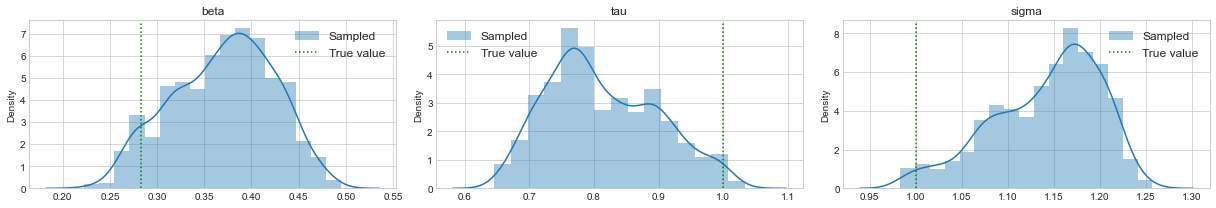

In [78]:
# Extract samples from inference
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}

nodes = ['beta', 'tau', 'sigma']
fig, axes = plt.subplots(1,3, figsize=(17,3))
true_values = [beta, tau, sigma]

for i, node in enumerate(nodes):
    sns.distplot(hmc_samples[node], label='Sampled', ax=axes[i])\
        .axvline(true_values[i], color='g', ls=':', label='True value')
    axes[i].legend(fontsize=12)
    axes[i].set_title(node)
fig.tight_layout()
plt.savefig('figures/parameter_dist_AR(1)_verification.png', bbox_inches='tight')

In [79]:
print('Estimated latent variables')
print('beta:', hmc_samples['beta'].mean())
print('tau:', hmc_samples['tau'].mean())
print('sigma:', hmc_samples['sigma'].mean())

Estimated latent variables
beta: 0.37004158
tau: 0.8133476
sigma: 1.1422306


In [17]:
print('True values of latent variables')
print('beta:', beta)
print('tau:', tau)
print('sigma:', sigma)

True values of latent variables
beta: 0.4967141530112327
tau: 1.0
sigma: 1.0


From the results, it is seen that the model approximates the parameters with a somewhat correct. The mean values are close to the true values used in the ancestral sampling process even though the prior values were set to be slightly off. The distribution for $\tau$ and $\sigma$ do not look like normal distributions but it is assumed that the model works regardless of this.

## Stationarity and Differencing

Temporal models such as the ARIMA model can only model stationary time series. A stationary time series has constant mean, variance, and autocorrelation over time. Therefore, trends and seasonality should be removed from the time series before modeling. The Augmented Dickey-Fuller (ADF) test can be used to test for stationarity. The null hypothesis is non-stationarity and the alternative hypothesis is stationarity [3].

In [18]:
f'p-value for ADF-test {sts.adfuller(df.DepDelayMinutes)[1]}'

'p-value for ADF-test 2.871052354984356e-05'

With a significance level of 0.05, the null-hypothesis is rejected and the ADF test indicates that the time series is stationary. Differencing can make the data more stationary by removing seasonality or trends. The graph below shows the original data and the data differenced by lag=1. 

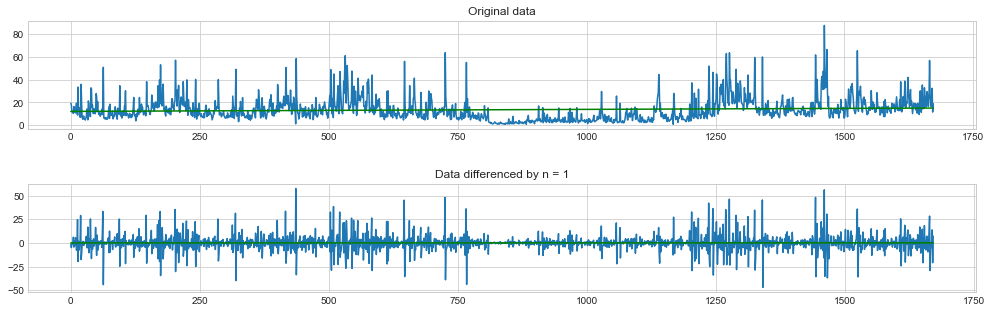

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(17,5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

y = df['DepDelayMinutes']
x = range(0, y.shape[0])

# Original data, no transformations
p = np.poly1d( np.polyfit(x, y.dropna(), 1))
ax[0].plot(x,y)
ax[0].plot(x, p(x), 'g-')
ax[0].set_title('Original data', fontsize=12);

# Differenced with 1
x1 = range(0, y.diff(1).dropna().shape[0])
p_diff1 = np.poly1d(np.polyfit(x1, y.diff(1).dropna(), 1))
ax[1].plot(x1,y.diff(1).dropna())
ax[1].plot(x1, p_diff1(x1), 'g-')
ax[1].set_title('Data differenced by n = 1', fontsize=12);
plt.savefig('figures/timeseries_differentiation.png', bbox_inches='tight')

By differencing by 1 lag, it seems like a trend in how the departure delay minutes variate over time is removed. To further investigate it, autocorrelation (ACF) and partial autocorrelation (PACF) are inspected. 

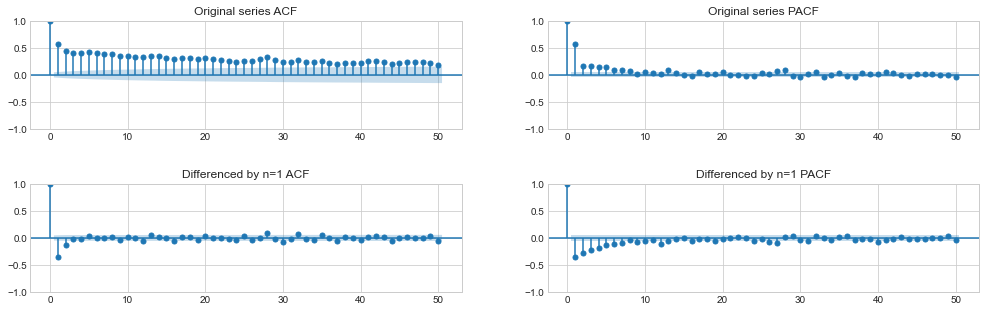

In [20]:
fig, axes = plt.subplots(2,2, figsize=(17,5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
axes = axes.flatten()
sm.graphics.tsa.plot_acf(y,title='Original series ACF',lags=50, ax=axes[0]);
sm.graphics.tsa.plot_pacf(y,title='Original series PACF',lags=50, ax=axes[1]);
sm.graphics.tsa.plot_acf(y.diff(1).dropna(),title='Differenced by n=1 ACF',lags=50, ax=axes[2]);
sm.graphics.tsa.plot_pacf(y.diff(1).dropna(),title='Differenced by n=1 PACF',lags=50, ax=axes[3]);
plt.savefig('figures/pacf_acf.png', bbox_inches='tight')

Looking at the ACF plot of the original data a slow decay in the ACF plot is seen indicating a trend or seasonality pattern. This slow decay pattern is removed from the time series that is differenced by 1 lag. As this indicates that differencing by 1 makes the time series more stationary, this data transformation is applied to the data.

The first two lags are significant in the PACF plot when the data is differenced once. This indicates that an AR(2) model is a potential fit for the data. 

In [21]:
# difference by 1
df['diff_DepDelayMinutes'] = df['DepDelayMinutes'].diff(1)

# Feature columns
X = df.drop(['DepDelayMinutes'],axis=1).iloc[1:]

# Target column differentiated
y = df['diff_DepDelayMinutes'].iloc[1:]

# Target column undifferentiated
v = df['DepDelayMinutes'].iloc[1:]

# Split in train and test data
X_train, X_test, y_train, y_test, v_train, v_test = train_test_split(X, y, v, test_size=0.10, shuffle=False)

In [22]:
print("N_train:", len(X_train))
print("N_test:", len(y_test))

N_train: 1504
N_test: 168


Once the prediction is made using a temporal model and differenced data, it needs to be backdifferenced to compare it to the original untransformed data. Below a helper function is defined as well as a function that can calculate confidence intervals for the predictions.

In [23]:
def BackDifferencing(y_train_undiffed, y_pred, y_train, test_start, lags=1):
    
    """
    Function to backdifference predicted values.
    """

    len_df = len(y_pred.T) + len(y_train) + lags
    restored = []
    y = []
    y.extend(np.full(lags, np.nan))
    y.extend(y_train)
    y.extend(y_pred.T) 
    y_diff = y[:test_start] + [i.mean() for i in y[test_start:]]
    
    for i in range(test_start-lags):
        restored.append(y_train_undiffed[i] + y_diff[i+lags])
    y_back= [np.nan]*(lags) + restored + [np.nan]*(len_df-test_start)

    for i in range(test_start-lags, len_df-lags):
        y_back[i+lags] = y_back[i] + y_diff[i+lags]

    for i in range(test_start-lags, len_df-lags):
        restored.append(y_back[i] + y[i+lags])

    y_back = [np.nan]*(lags) + restored
    y_pred = y_back[:test_start] + [i.mean() for i in y_back[test_start:]]

    return pd.Series(y_pred).astype(float)

In [24]:
def CI95(y_pred):
    """
    Calculated 95% confidence intervals for predictions.
    """
    return pd.Series([1.96*i.std() for i in y_pred.T]).astype(float)

## AR(1) Model

With a model that is verified in the previous section. It can now be tried on the real data. The model priors of $\beta$, $\tau$, $\sigma$, $z_1$ and $\epsilon$ are assigned by a trial and error. For an indication of correct values, the time series plot of the differenced time series is used. Here it is seen that the values are centered around zero and mainly fluctuate between 0 and 10.

Below the model is applied to the actual data, modeling the departure delay minutes. 

In [25]:
def f(carry, noise_t):
    """
    Function used to propogate dynamics
    """
    beta, z_prev, tau = carry
    z_t = beta*z_prev + tau*noise_t
    z_prev = z_t
    return (beta, z_prev, tau), z_t

def model(T, T_forecast, obs=None):
    """
    AR(1)-model
    """
    # Priors over beta, tau, noises, sigma, z_1
    beta  = numpyro.sample('beta', numpyro.distributions.Normal(0.,1.))
    tau = numpyro.sample('tau', numpyro.distributions.HalfCauchy(.01))
    sigma = numpyro.sample('sigma', numpyro.distributions.HalfCauchy(0.1))
    z_1 = numpyro.sample('z_1', numpyro.distributions.Normal(0.,1.))
    noises = numpyro.sample('noises', numpyro.distributions.Normal(0.,1.),
                            sample_shape=(T+T_forecast-1,))# -1 as AR(1)
    
    # Propagate the dynamics forward using jax.lax.scan
    carry = (beta, z_1, tau)
    z_collection = jnp.array([z_1])
    carry_updated, z_collection2 = lax.scan(f=f, init=carry, xs=noises, length=T+T_forecast-1)
    z_collection = jnp.concatenate((z_collection,z_collection2))
    
    # Sample the observed y (y_obs) and prediction y (y_pred)
    y_obs  = numpyro.sample('y_obs', numpyro.distributions.Normal(z_collection[:T],sigma),obs=obs[:T])
    y_pred = numpyro.sample('y_pred', numpyro.distributions.Normal(z_collection[T:],sigma),obs=None)
    
    return z_collection

In [26]:
# Run inference using MCMC
t0 = time.time()
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

nuts_kernel = NUTS(model=model)
mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=len(y_train), T_forecast=len(y_test), obs=y.values)

t_fin = time.time()

print('Total time: {0:.3f}m'.format((t_fin - t0)/60))

sample: 100%|██████████████████████████| 3000/3000 [00:50<00:00, 59.40it/s, 255 steps of size 2.46e-02. acc. prob=0.20]


Total time: 0.946m


In [28]:
# Extract samples from inference
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}
ar1_pred = BackDifferencing(df['DepDelayMinutes'], hmc_samples['y_pred'], y_train, len(y_train)+1)
ar1_std =CI95(hmc_samples['y_pred'])

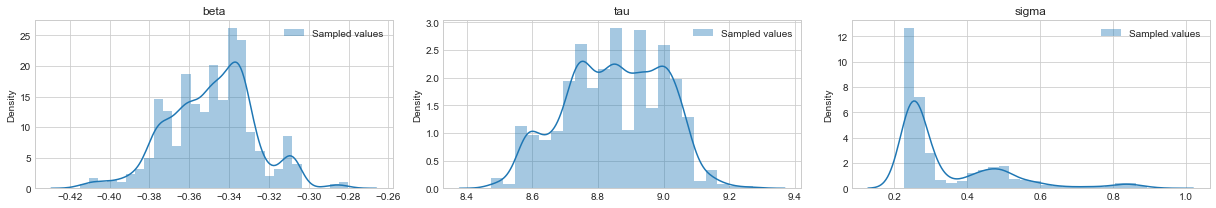

In [29]:
# Visualization of the posterior distributions
nodes = ['beta', 'tau', 'sigma']
fig, axes = plt.subplots(1,3, figsize=(17,3))
axes = axes.flatten()
for i, node in enumerate(nodes):
    axes[i].set_title(node)
    sns.distplot(hmc_samples[node], label='Sampled values', ax=axes[i])
    axes[i].legend()
fig.tight_layout()
plt.savefig('figures/parameter_dist_AR(1).png', bbox_inches='tight')

It is seen that $\boldsymbol{\tau}$ values are quite significant compared to the $\boldsymbol{\beta}$ and $\boldsymbol{\sigma}$ values, as the sample values are higher. This indicates that global variance is high. A lower  $\boldsymbol{\beta}$  value indicates that the previous time step t-1 is less important in predicting the target value. 

The helper function below plots the true test values and the predicted values with their standard deviation.

In [42]:
def plot_preds(y_pred, y_pred_std, y_true, model_name):
    plot_df = pd.DataFrame()
    plot_df['true'] = y_true
    plot_df['pred'] = np.array(y_pred.mean(axis=0))

    plot_df['pred_025'] = plot_df['pred'].values - y_pred_std.values
    plot_df['pred_975'] = plot_df['pred'].values + y_pred_std.values

    fig, ax = plt.subplots( figsize = (17, 3))
    plot_df['true'].plot(style='g-', marker='o', label='True values')
    plot_df['pred'].plot(style='b-', marker='o', label='Predicted values')
    plot_df['pred_025'].plot(style='b--')
    plot_df['pred_975'].plot(style='b--')
    plt.fill_between(plot_df['pred_025'].index, plot_df['pred_025'], plot_df['pred_975'], alpha=0.3, 
                     label='95% confidence interval', color='b')
    plt.title('Predicted test values')

    plt.legend(['True values','Predicted', '95% confidence interval'], loc='upper right', ncol=3);
    plt.savefig(f'figures/predictions_{model_name}.png', bbox_inches='tight');

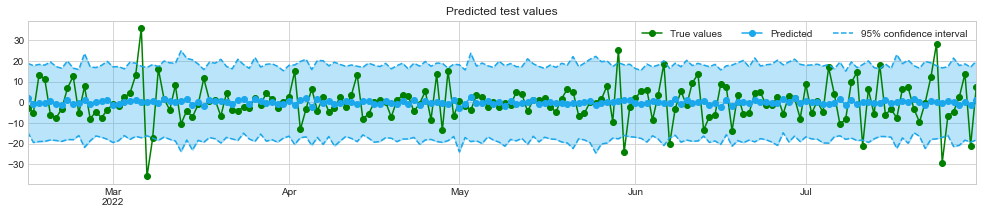

In [43]:
plot_preds(hmc_samples['y_pred'], ar1_std, y_test, 'Ar1')

As it was indicated from the distribution plots of  $\boldsymbol{\beta}$, $\boldsymbol{\sigma}$ and $\boldsymbol{\tau}$, the model is not able to learn from the data. Instead, it almost just predicts the global mean. It is seen from the confidence interval is wide and contains most of the observations. However, the trends in the data are only slightly detected by the model and the upward and downward trends seem quite random. For instance, it does not detect that there is a period around March 2022 where the delay time is increasing each day. 

To be able to compare the model with other models it is evaluated using the evaluate function defined above. 

In [44]:
results_dict = evaluate(np.array(hmc_samples['y_pred'].mean(axis=0)), y_test)
results = pd.DataFrame(results_dict.values(), results_dict.keys(), columns=['AR(1)'])
results

,AR(1)
mse,90.405778
r2,-0.030846
mae,6.944925


As the AR(1) model is the simplest of the temporal models, these metric scores will be used as a baseline that can be compared with the more complex models. 

## AR(2) Model

The second temporal mode that is tested out is the AR(2) model. This additional complexity could improve the model as indicated in the PACF plot seen in the previous section. 

In [62]:
# Scan function to propogate dynamics (incl 2 prev)
def f(carry, noise_t):
    """
    Function used to propogate dynamics
    """
    beta1, beta2, z_prev1, z_prev2, tau = carry
    z_t = beta1*z_prev1 + beta2*z_prev2 + tau*noise_t
    z_prev2 = z_prev1
    z_prev1 = z_t
    return (beta1, beta2, z_prev1, z_prev2, tau), z_t

def model(T, T_forecast, obs=None):
    """
    AR(2)-model
    """ 
    # Define priors
    beta1 = numpyro.sample('beta_1', numpyro.distributions.Normal(0.,1.))
    beta2 = numpyro.sample('beta_2', numpyro.distributions.Normal(0.,1.))
    tau = numpyro.sample('tau', numpyro.distributions.HalfCauchy(.01))
    noises = numpyro.sample('noises', numpyro.distributions.Normal(0., 1.), 
                            sample_shape=(T+T_forecast-2,)) # -2 because AR(2)
    sigma = numpyro.sample('sigma', numpyro.distributions.HalfCauchy(.01))
    z_prev1 = numpyro.sample('z_1', numpyro.distributions.Normal(0,.1))
    z_prev2 = numpyro.sample('z_2', numpyro.distributions.Normal(0,.1))
    
    # Propagate the dynamics forward using jax.lax.scan
    carry = (beta1, beta2, z_prev1, z_prev2, tau)
    z_collection = [z_prev1, z_prev2]
    carry, zs_exp = lax.scan(f, carry, noises, T+T_forecast-2)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)
    
    # Sample the observed y (y_obs) and prediction y (y_pred)
    y_obs  = numpyro.sample('y_obs', numpyro.distributions.Normal(z_collection[:T],sigma),obs=obs[:T])
    y_pred = numpyro.sample('y_pred', numpyro.distributions.Normal(z_collection[T:],sigma),obs=None)
    return z_collection

In [63]:
# Run inference using MCMC

t0 = time.time()
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

nuts_kernel = NUTS(model=model)
mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=len(y_train), T_forecast=len(y_test), obs=y.values)

t_fin = time.time()

print('Total time: {0:.3f}m'.format((t_fin - t0)/60))

sample: 100%|█████████████████████████| 3000/3000 [02:29<00:00, 20.07it/s, 1023 steps of size 3.00e-03. acc. prob=0.96]


Total time: 2.550m


Again, we extract the values from the predictions and inspect the posterior distributions.

In [64]:
# Extract samples from inference
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}
ar2_pred = BackDifferencing(df['DepDelayMinutes'], hmc_samples['y_pred'], y_train, len(y_train)+1)
ar2_std = CI95(hmc_samples['y_pred'])

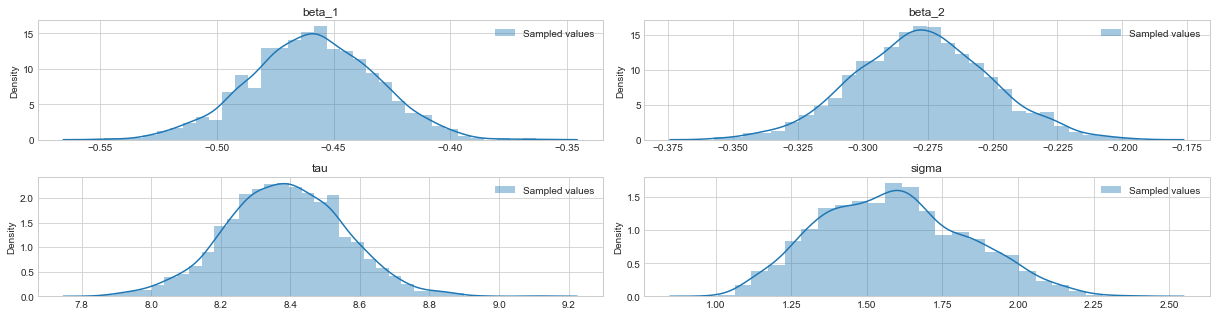

In [66]:
# Visualization of the posterior distributions
nodes = ['beta_1', 'beta_2', 'tau', 'sigma']
fig, ax = plt.subplots(2,2, figsize=(17, 4.5))
axes = ax.flatten()
for i, node in enumerate(nodes):
    axes[i].set_title(node)
    sns.distplot(hmc_samples[node], label='Sampled values', ax=axes[i])
    axes[i].legend()
fig.tight_layout()
plt.savefig('figures/parameter_dist_AR(2).png', bbox_inches='tight')

Again we see that the $\boldsymbol{\tau}$ is fairly significant compared to the $\boldsymbol{\beta}$ and $\boldsymbol{\sigma}$ parameters indicating the global variance is significant and that the model is not able to accurately predict the target value. However, it is notable that the values for $\boldsymbol{\beta}1$ are higher than for  $\boldsymbol{\beta}2$ indicating that the model learns more from time step t-1 than timestep t-2 as we would expect.

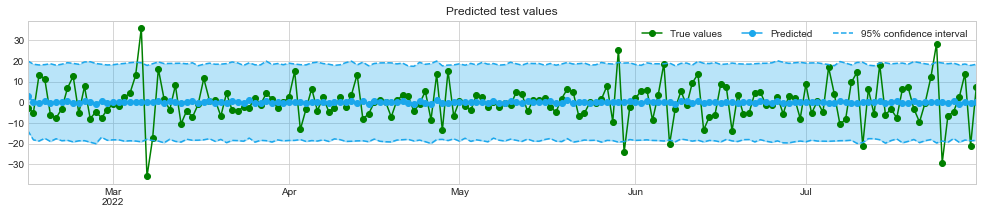

In [53]:
plot_preds(hmc_samples['y_pred'], ar2_std, y_test, 'Ar2')

In [54]:
results_dict = evaluate(np.array(hmc_samples['y_pred'].mean(axis=0)), y_test)
results['AR(2)'] = results_dict.values()
results

,AR(1),AR(2)
mse,90.405778,88.048606
r2,-0.030846,-0.003969
mae,6.944925,6.812383


Looking at the plot and the graph of the predicted values, it is seen that the model again is not learning much from the previous values, instead the global variance is significant. Comparing the predictions from the AR(1) and AR(2) models, it is seen that predictions are more steady around the global mean for the AR(2) model. Though looking at the scores of the evaluation metrics, it is seen that the model has improved compared to the AR(1) model on all the evaluated metrics.

## AR(2) with Weather Features

The last AR model that will be tried is an AR(2) model including the weather features. The weather conditions might be causing some departure delay hence it is interesting to investigate if this data can make the predictions better. 

In [55]:
# Scan for propagation w/ weather data
def f(carry, xs):
    """
    Function used to propogate dynamics
    """
    x_t, noise_t = xs
    tavg = x_t[0]
    prcp = x_t[1]
    wdir = x_t[2]
    wspd = x_t[3]
    pres = x_t[4]
    
    beta1, beta2, alpha1, alpha2, alpha3, alpha4, alpha5, z_prev1, z_prev2, tau = carry
    z_t = beta1*z_prev1+beta2*z_prev2+tavg*alpha1+prcp*alpha2+wdir*alpha3+wspd*alpha4+pres*alpha5+tau*noise_t
    z_prev2 = z_prev1
    z_prev1 = z_t
    return (beta1, beta2, alpha1, alpha2, alpha3, alpha4, alpha5, z_prev1, z_prev2, tau), z_t

def model(T, T_forecast, x, obs=None):
    """
    AR(2)-model including weather features
    """ 
    # Defining priors
    beta1 = numpyro.sample('beta_1', numpyro.distributions.Normal(0.,1.))
    beta2 = numpyro.sample('beta_2', numpyro.distributions.Normal(0.,1.))
    tau = numpyro.sample('tau', numpyro.distributions.HalfCauchy(.01))
    noises = numpyro.sample('noises', numpyro.distributions.Normal(0., 1.), 
                            sample_shape=(T+T_forecast-2,)) # -2 because AR(2)
    sigma = numpyro.sample('sigma', numpyro.distributions.HalfCauchy(.01))

    # Priors for weather features
    alpha1 = numpyro.sample('alpha_1', numpyro.distributions.Normal(0.,1.))
    alpha2 = numpyro.sample('alpha_2', numpyro.distributions.Normal(0.,1.))
    alpha3 = numpyro.sample('alpha_3', numpyro.distributions.Normal(0.,1.))
    alpha4 = numpyro.sample('alpha_4', numpyro.distributions.Normal(0.,1.))
    alpha5 = numpyro.sample('alpha_5', numpyro.distributions.Normal(0.,1.))
    
    z_prev1 = numpyro.sample('z_1', numpyro.distributions.Normal(0,.1))
    z_prev2 = numpyro.sample('z_2', numpyro.distributions.Normal(0,.1))

    # Propagate the dynamics forward using jax.lax.scan
    carry = (beta1, beta2, alpha1, alpha2, alpha3, alpha4, alpha5, z_prev1, z_prev2, tau)
    z_collection = [z_prev1, z_prev2]
    xs = (x, noises)
    carry, zs_exp = lax.scan(f, carry, xs, T+T_forecast-2)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)
    
    # Sample the observed_y (y_obs) and predicted_y (y_pred)
    numpyro.sample('y_obs', numpyro.distributions.Normal(z_collection[:T], sigma), obs=obs[:T])
    numpyro.sample('y_pred', numpyro.distributions.Normal(z_collection[T:], sigma), obs=None)
    
    return z_collection

In [56]:
# Weather features, excluding the first to obs
weather_X = jnp.vstack((X[['tavg','prcp','wdir','wspd','pres']].fillna(0).values[2:,:])) 

In [57]:
# Run inference using MCMC
t0 = time.time()

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

nuts_kernel = NUTS(model=model)
mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=len(y_train), T_forecast=len(y_test), x=weather_X, obs=y_train.values)

t_fin = time.time()

print('Total time: {0:.3f}m'.format((t_fin - t0)/60))

sample: 100%|██████████████████████████| 3000/3000 [01:36<00:00, 30.97it/s, 255 steps of size 2.17e-02. acc. prob=0.92]


Total time: 1.725m


In [58]:
# Extract samples from inference
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}
ar2e_pred = BackDifferencing(df['DepDelayMinutes'], hmc_samples['y_pred'], y_train, len(y_train)+1)
ar2e_std = CI95(hmc_samples['y_pred'])

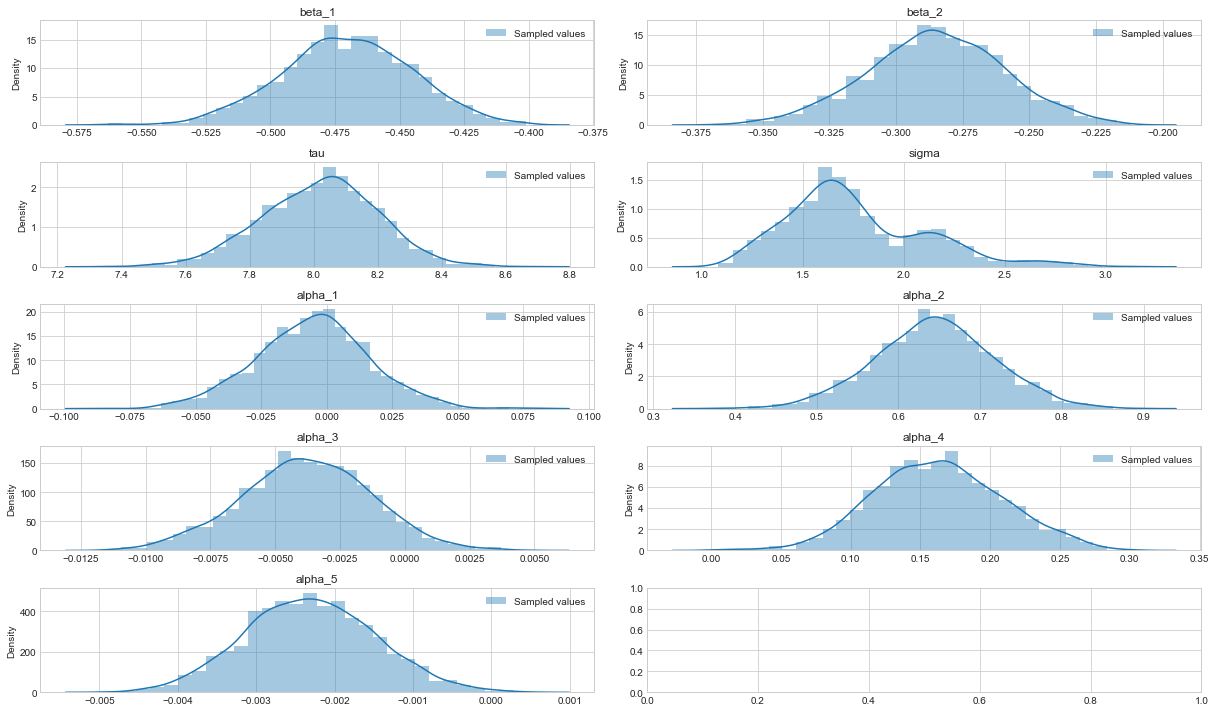

In [60]:
# Visualization of the posterior distributions
nodes = ['beta_1','beta_2', 'tau', 'sigma', 'alpha_1', 'alpha_2', 'alpha_3', 'alpha_4', 'alpha_5']
fig, ax = plt.subplots(5,2, figsize=(17,10))
axes = ax.flatten()

for i, node in enumerate(nodes):
    axes[i].set_title(node)
    sns.distplot(hmc_samples[node], label='Sampled values', ax=axes[i])
    axes[i].legend()
fig.tight_layout()
plt.savefig('figures/parameter_dist_AR(2)_weather.png', bbox_inches='tight')

As for the other models, it is seen that the $\boldsymbol{\tau}$ value is significant compared to the other parameters. 

Of the  $\boldsymbol{\alpha}$ values, $\boldsymbol{\alpha}2$ and $\boldsymbol{\alpha}4$ are most significant. This indicates precipitation and windspeed are the most significant weather features of the modeled weather features. 

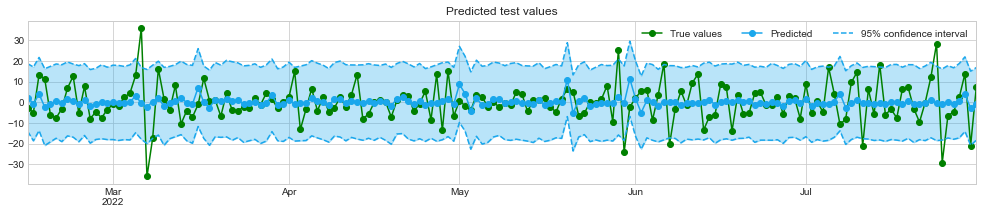

In [61]:
plot_preds(hmc_samples['y_pred'], ar2e_std, y_test, 'Ar2_weather')

In [41]:
results_dict = evaluate(np.array(hmc_samples['y_pred'].mean(axis=0)), y_test)
results['AR(2)-Weather'] = results_dict.values()
results

,AR(1),AR(2),AR(2)-Weather
mse,90.405778,88.048606,86.213370
r2,-0.030846,-0.003969,0.016957
mae,6.944925,6.812383,6.755908


Looking at the plot for the predicted values and evaluation metrics scores, it is seen that the model does perform better than the AR(2)-model without the external weather features. The model's mse, $r^2$, and mae scores are all slightly better than for the simple AR(1) and AR(2) models. The predictions are all just the global mean. Instead, some spikes are seen in the predicted values following the trend of the data. Still, the confidence interval is pretty wide, containing most of the predicted values except the major fluctuations in delay times. 

This indicates, that the weather features can explain some of the reasons why flights are delayed at departure. 

## Discussion 

- The best-performing model is the AR(2) model which includes weather features. Even though there only were small correlations with the weather data, the weather seems to explain some of the departure delay times. The model performs better by looking at all the evaluation metrics. 

- The mae score shows that the model in general is approximately 7 minutes off. Also, the model is not really able to detect when there are major spikes which would be ideal. 

**Data**
- There is a period in the dataset where Corona has caused a lot of flight cancellations. This might influence the models to predict the global mean value. As these flights were canceled, the departure delay time was set to zero. 

**Modelling**

- Discuss the MCMC choise

- The mean value is predicted but does that really make sense? At least the weather data cannot be accurately aligned. 

**Future work**
- The modeling could be done for each terminal that would likely yield better results as one terminal's delays maybe does not affect the other terminals. 



## Conclusion

## Sources

[1] Tileagă, C., & Oprișan, O. (2021). Flights delay compensation 261/2004: A challenge for airline companies? Paper presented at the Springer Proceedings in Business and Economics, 335-344. doi:10.1007/978-3-030-50676-6_27 Retrieved from www.scopus.com

[2] https://www.metoffice.gov.uk/weather/warnings-and-advice/seasonal-advice/travel/why-does-the-weather-affect-flights

[3] https://www.linkedin.com/advice/0/what-advantages-disadvantages-stationarizing-your-data